In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import quantstats as qs
import ta 
from sklearn.neighbors import KNeighborsClassifier

In [2]:
spy_data = yf.Ticker('^SPX').history(period="max")
spy_data.index = spy_data.index.tz_localize(None)
spy_data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)
spy_data

,Open,High,Low,Close,Volume
Date,,,,,
1927-12-30,17.660000,17.660000,17.660000,17.660000,0
1928-01-03,17.760000,17.760000,17.760000,17.760000,0
1928-01-04,17.719999,17.719999,17.719999,17.719999,0
1928-01-05,17.549999,17.549999,17.549999,17.549999,0
1928-01-06,17.660000,17.660000,17.660000,17.660000,0
...,...,...,...,...,...
2023-07-24,4543.390137,4563.410156,4541.290039,4554.640137,3856250000
2023-07-25,4555.189941,4580.620117,4552.419922,4567.459961,3812470000
2023-07-26,4558.959961,4582.470215,4547.580078,4566.750000,3990290000


In [34]:
def KNN_para_optim(ticker_df, roc_par, sma_par, atr_par, knn_par, train_ratio):
    
    ticker_df = ticker_df.copy()
    ticker_df['ROC'] = ta.momentum.ROCIndicator(ticker_df['Close'], window=roc_par).roc()
    ticker_df['EMA'] = ta.trend.ema_indicator(ticker_df['Close'], window=sma_par)
    ticker_df['ATR'] = ta.volatility.AverageTrueRange(high=ticker_df['High'], 
                                                     low=ticker_df['Low'], 
                                                     close=ticker_df['Close'], window=atr_par).average_true_range()
    ticker_df['%_change'] = ticker_df['Close'].pct_change()
    ticker_df['%_change + 1'] = ticker_df['%_change'].shift(-1)
    ticker_df['y_label'] = [int(label) for label in ticker_df['%_change + 1'] > 0]
    ticker_df['y_label'][-1] = np.nan
    ticker_df.dropna(inplace=True)
    
    ticker_df.drop(['Open', 'High', 'Low', '%_change', '%_change + 1'], axis=1, inplace=True)
    
    training_data_index = int(len(ticker_df)*train_ratio)
    train_period = ticker_df.iloc[:training_data_index]
    strategy_period = ticker_df.iloc[training_data_index:]
    
    open_date, close_date, equity_list = simple_KNN_strategy(train_period, strategy_period, knn_par)
    equity_list = pd.Series(equity_list, index=strategy_period.index)
    
    sharpe = qs.stats.sharpe(equity_list)
    cagr = qs.stats.cagr(equity_list)
    mdd = qs.stats.max_drawdown(equity_list)
    calmar = qs.stats.calmar(equity_list)
    freq = len(open_date)
    
    return sharpe, cagr, mdd, calmar, freq

In [5]:
def simple_KNN_strategy(train_df, strategy_df, n):
    
    initial_capital = 100000
    lot = 0
    last_realized_capital = initial_capital
    unrealized_pnl = 0
    equity =  last_realized_capital + unrealized_pnl
    open_price = 0
    equity_list = []
    open_date = []
    close_date = []
    
    X = train_df.drop('y_label', axis=1)
    y = train_df['y_label']
    
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X.values, y)
    
    for date, row in strategy_df.iterrows():
        
        unrealized_pnl = (row['Close']-open_price)*lot
        equity =  last_realized_capital + unrealized_pnl
        
        input_feature = row.drop('y_label')
        KNN_prediction = knn.predict(np.array(input_feature).reshape(1,-1))[0]
        
        if KNN_prediction == 1:
            
            if lot == 0:
                open_price = row['Close']
                lot = last_realized_capital // open_price
                open_date.append(date)
#             elif lot < 0:
#                 close_price = row['Close']
#                 realized_pnl = unrealized_pnl
#                 last_realized_capital += realized_pnl
                
#                 open_price = row['Close']
#                 lot = last_realized_capital // open_price
        
        elif KNN_prediction == 0: 
            # if lot == 0:
            #     open_price = row['Close']
            #     lot = -last_realized_capital // open_price
            if lot > 0:
                close_price = row['Close']
                realized_pnl = unrealized_pnl
                last_realized_capital += realized_pnl
                lot = 0
                close_date.append(date)
                # open_price = row['Close']
                # lot = -last_realized_capital // open_price
        
        equity_list.append(equity)
        
        if strategy_df.index[0] != date:
            new_data_point = strategy_df.iloc[strategy_df.index.get_loc(date)-1]
            train_df = pd.concat([train_df, new_data_point.to_frame().T], axis=0)
            X = train_df.drop('y_label', axis=1)
            y = train_df['y_label']
            knn.fit(X.values, y)
    
    return open_date, close_date, equity_list

In [35]:
roc_par_list = range(10, 12)
sma_par_list = range(9, 11)
atr_par_list = range(12, 15)
knn_par_list = range(40, 51)

result_dict = {}
result_dict['roc_par'] = []
result_dict['sma_par'] = []
result_dict['atr_par'] = []
result_dict['knn_par'] = []
result_dict['Sharpe'] = []
result_dict['CAGR'] = []
result_dict['MDD'] = []
result_dict['Calmar'] = []
result_dict['Freq'] = []
    
for roc_par in roc_par_list:
    for sma_par in sma_par_list:
        for atr_par in atr_par_list:
            for knn_par in knn_par_list:
                sharpe, cagr, mdd, calmar, freq = KNN_para_optim(spy_data, roc_par, sma_par, atr_par, knn_par, .4)
                
                result_dict['roc_par'].append(roc_par)
                result_dict['sma_par'].append(sma_par)
                result_dict['atr_par'].append(atr_par)
                result_dict['knn_par'].append(knn_par)
                result_dict['Sharpe'].append(sharpe)
                result_dict['CAGR'].append(cagr)
                result_dict['MDD'].append(mdd)
                result_dict['Calmar'].append(calmar)
                result_dict['Freq'].append(freq)
                
result_df = pd.DataFrame.from_dict(result_dict)

In [36]:
result_df.sort_values(by='Sharpe', ascending=False).head(20)

,roc_par,sma_par,atr_par,knn_par,Sharpe,CAGR,MDD,Calmar,Freq
64,10,10,14,49,0.489587,0.102495,-0.731802,0.140058,1556
42,10,10,12,49,0.489587,0.102495,-0.731802,0.140058,1556
53,10,10,13,49,0.489587,0.102495,-0.731802,0.140058,1556
9,10,9,12,49,0.489587,0.102495,-0.731802,0.140058,1556
31,10,9,14,49,0.489587,0.102495,-0.731802,0.140058,1556
20,10,9,13,49,0.489587,0.102495,-0.731802,0.140058,1556
86,11,9,13,49,0.489285,0.102396,-0.728808,0.140498,1557
75,11,9,12,49,0.489285,0.102396,-0.728808,0.140498,1557
130,11,10,14,49,0.489285,0.102396,-0.728808,0.140498,1557
97,11,9,14,49,0.489285,0.102396,-0.728808,0.140498,1557


In [16]:
result_df.to_csv('looping_result_no_Freq.csv',index = True, encoding='utf-8')

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2018-05-01  2018-05-01
End Period                 2023-07-14  2023-07-14
Risk-Free Rate             0.0%        0.0%
Time in Market             68.0%       100.0%

Cumulative Return          342.34%     1,307.28%
CAGR﹪                     33.06%      66.19%

Sharpe                     0.79        1.1
Prob. Sharpe Ratio         96.42%      99.42%
Smart Sharpe               0.75        1.05
Sortino                    1.18        1.67
Smart Sortino              1.13        1.59
Sortino/√2                 0.84        1.18
Smart Sortino/√2           0.8         1.13
Omega                      1.19        1.19

Max Drawdown               -60.62%     -73.63%
Longest DD Days            555         616
Volatility (ann.)          56.67%      65.81%
R^2                        0.74        0.74
Information Ratio          -0.05       -0.05
Calmar                     0.55    

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-20,2020-03-18,2020-07-10,141,-60.617813,-53.390974
2,2022-01-05,2023-01-03,2023-07-14,555,-49.681776,-47.373084
3,2018-08-08,2019-05-01,2020-01-30,540,-39.109696,-38.446465
4,2021-01-27,2021-03-08,2021-10-25,271,-36.242117,-35.258193
5,2020-09-01,2020-09-08,2021-01-07,128,-33.735035,-26.496785


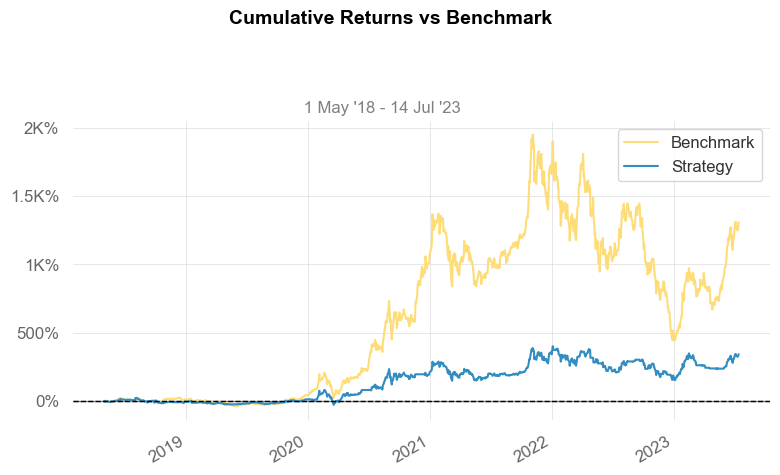

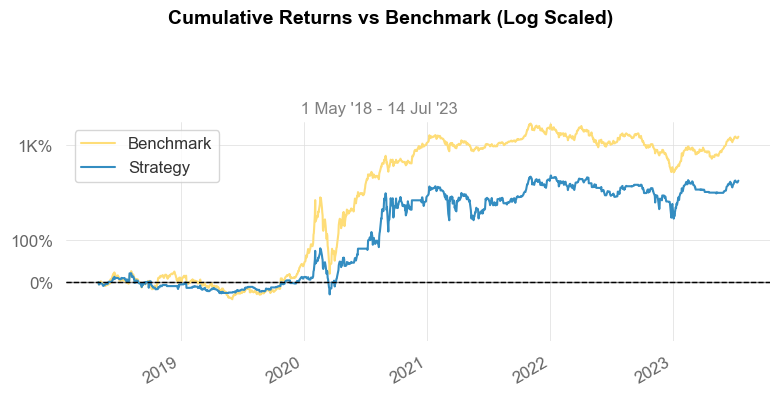

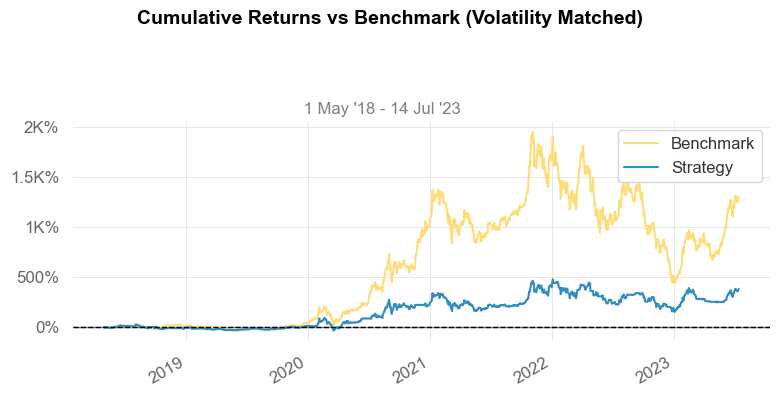

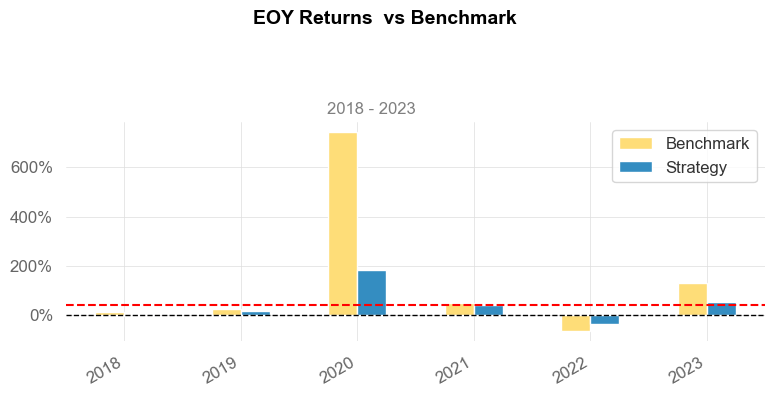

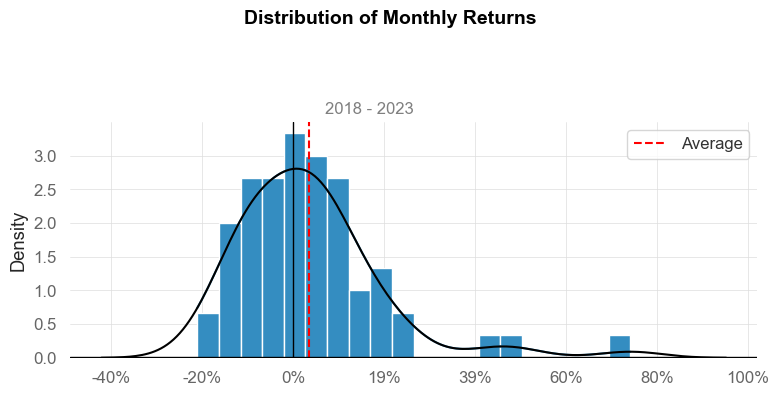

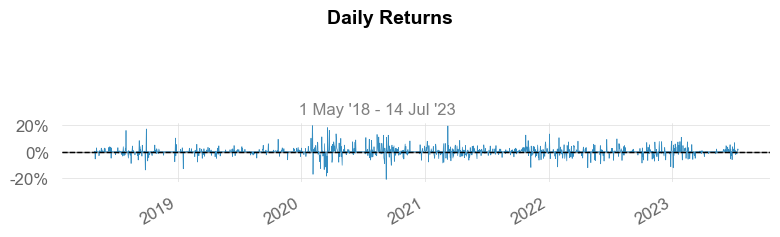

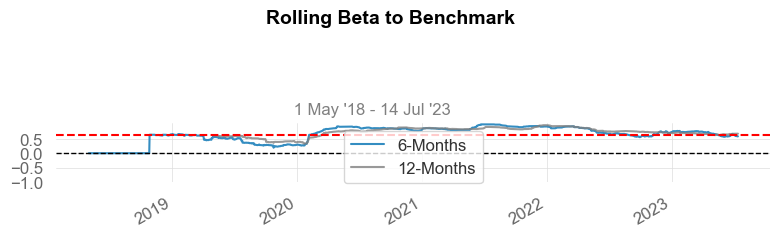

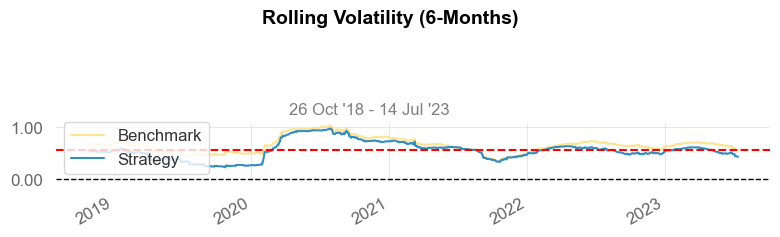

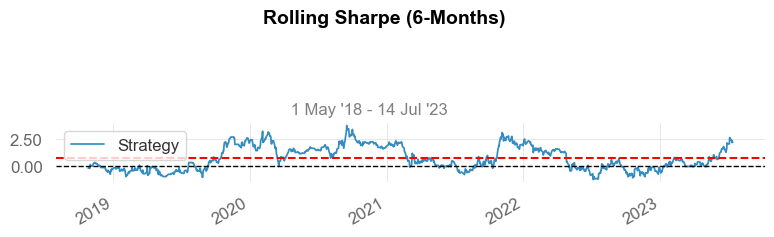

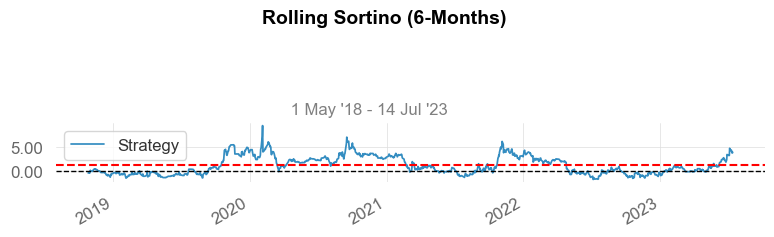

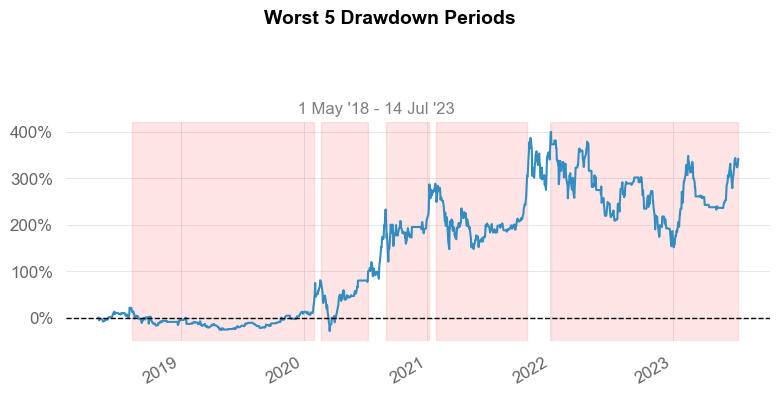

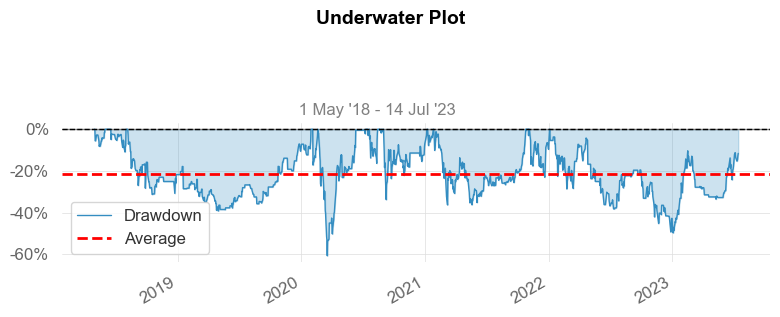

/opt/anaconda3/lib/python3.9/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


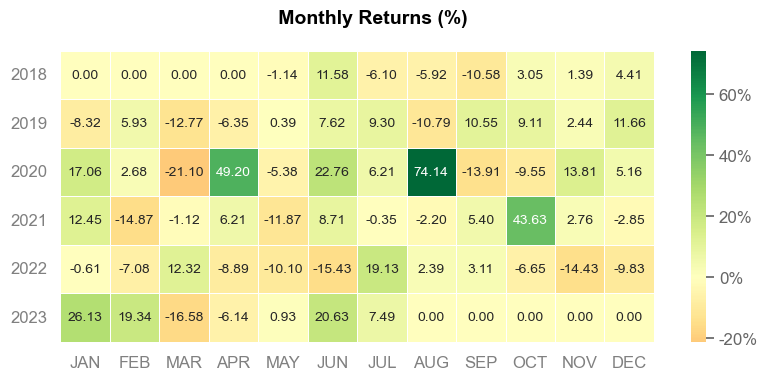

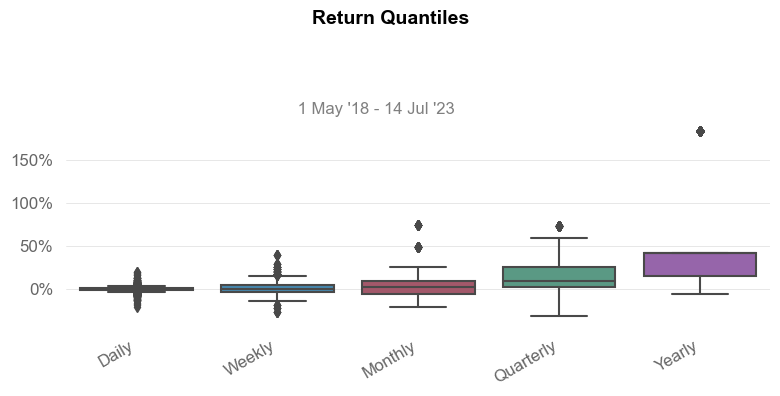

In [160]:
spy_data = yf.Ticker('TSLA').history(period="max")
spy_data.index = spy_data.index.tz_localize(None)
spy_data.drop(['Dividends', 'Stock Splits', 'Volume'], axis=1, inplace=True)

ticker_df = spy_data.copy()
ticker_df['ROC'] = ta.momentum.ROCIndicator(ticker_df['Close'], window=10).roc()
ticker_df['SMA'] = ta.trend.ema_indicator(ticker_df['Close'], window=10)
ticker_df['ATR'] = ta.volatility.AverageTrueRange(high=ticker_df['High'], 
                                                 low=ticker_df['Low'], 
                                                 close=ticker_df['Close'], window=13).average_true_range()
ticker_df['%_change'] = ticker_df['Close'].pct_change()
ticker_df['%_change + 1'] = ticker_df['%_change'].shift(-1)
ticker_df['y_label'] = [int(label) for label in ticker_df['%_change + 1'] > 0]
ticker_df['y_label'][-1] = np.nan
ticker_df.dropna(inplace=True)

ticker_df.drop(['Open', 'High', 'Low', '%_change', '%_change + 1'], axis=1, inplace=True)

training_data_index = int(len(ticker_df)*.6)
train_period = ticker_df.iloc[:training_data_index]
strategy_period = ticker_df.iloc[training_data_index:]

open_date, close_date, equity_list = simple_KNN_strategy(train_period, strategy_period, 41)
equity_list = pd.Series(equity_list, index=strategy_period.index)

benchmark = qs.utils.download_returns('TSLA')
benchmark.index = benchmark.index.tz_localize(None)
qs.reports.full((equity_list), benchmark=benchmark)

<h1> Combine

In [161]:
def Two_model_combine_strategy(train_df, strategy_df, n, model2_prediction_df):
    
    initial_capital = 100000
    lot = 0
    last_realized_capital = initial_capital
    unrealized_pnl = 0
    equity =  last_realized_capital + unrealized_pnl
    open_price = 0
    equity_list = []
    open_date = []
    close_date = []
    
    X = train_df.drop('y_label', axis=1)
    y = train_df['y_label']
    
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X.values, y)
    
    for date, row in strategy_df.iterrows():
        
        unrealized_pnl = (row['Close']-open_price)*lot
        equity =  last_realized_capital + unrealized_pnl
        
        input_feature = row.drop('y_label')
        KNN_prediction = knn.predict(np.array(input_feature).reshape(1,-1))[0]
        
        if KNN_prediction == 1 and model2_prediction_df.loc[date]['Buy_signal'] == 1:
            
            if lot == 0:
                open_price = row['Close']
                lot = last_realized_capital // open_price
                open_date.append(date)
#             elif lot < 0:
#                 close_price = row['Close']
#                 realized_pnl = unrealized_pnl
#                 last_realized_capital += realized_pnl
                
#                 open_price = row['Close']
#                 lot = last_realized_capital // open_price
        
        elif KNN_prediction == 0 and model2_prediction_df.loc[date]['Buy_signal'] == 0: 
            # if lot == 0:
            #     open_price = row['Close']
            #     lot = -last_realized_capital // open_price
            if lot > 0:
                close_price = row['Close']
                realized_pnl = unrealized_pnl
                last_realized_capital += realized_pnl
                lot = 0
                close_date.append(date)
                # open_price = row['Close']
                # lot = -last_realized_capital // open_price
        
        equity_list.append(equity)
        
        if strategy_df.index[0] != date:
            new_data_point = strategy_df.iloc[strategy_df.index.get_loc(date)-1]
            train_df = pd.concat([train_df, new_data_point.to_frame().T], axis=0)
            X = train_df.drop('y_label', axis=1)
            y = train_df['y_label']
            knn.fit(X.values, y)
    
    return open_date, close_date, equity_list

In [162]:
model2_predict_df = pd.read_csv('predict2withxgboost.csv')
model2_predict_df.set_index('trade_date', inplace=True)
model2_predict_df.index = pd.to_datetime(model2_predict_df.index)
model2_predict_df.index = model2_predict_df.index.tz_localize(None)

# model2_predict_df['close'] = [close.replace('[', '') for close in model2_predict_df['close']]
# model2_predict_df['close'] = [float(close.replace(']', '')) for close in model2_predict_df['close']]
# model2_predict_df['predict'] = [predict.replace('[', '') for predict in model2_predict_df['predict']]
# model2_predict_df['predict'] = [float(predict.replace(']', '')) for predict in model2_predict_df['predict']]


model2_predict_df['predict'] = model2_predict_df['predict'].shift(-1)
model2_predict_df.dropna(inplace=True)

model2_predict_df['change'] = model2_predict_df['predict']- model2_predict_df['close']
model2_predict_df['Buy_signal'] = [int(signal) for signal in model2_predict_df['change']>0]

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2013-05-16  2013-05-16
End Period                 2023-07-13  2023-07-13
Risk-Free Rate             0.0%        0.0%
Time in Market             50.0%       100.0%

Cumulative Return          150.97%     228.39%
CAGR﹪                     9.48%       12.41%

Sharpe                     0.77        0.76
Prob. Sharpe Ratio         99.21%      99.14%
Smart Sharpe               0.71        0.7
Sortino                    1.08        1.06
Smart Sortino              0.99        0.98
Sortino/√2                 0.76        0.75
Smart Sortino/√2           0.7         0.69
Omega                      1.22        1.22

Max Drawdown               -19.43%     -33.72%
Longest DD Days            734         555
Volatility (ann.)          12.83%      17.42%
R^2                        0.55        0.55
Information Ratio          -0.02       -0.02
Calmar                     0.49      

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-01-20,2022-09-30,2023-07-12,538,-19.426341,-18.528447
2,2015-08-11,2016-02-11,2017-08-14,734,-17.672686,-15.914403
3,2018-12-06,2018-12-24,2019-02-04,60,-12.757249,-10.361973
4,2020-02-07,2020-04-01,2020-04-09,62,-10.757491,-10.103489
5,2018-10-05,2018-10-29,2018-11-28,54,-9.052810,-8.457207


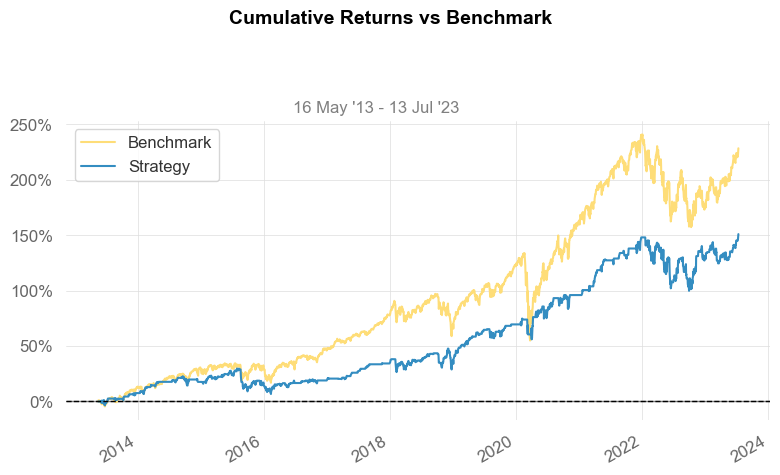

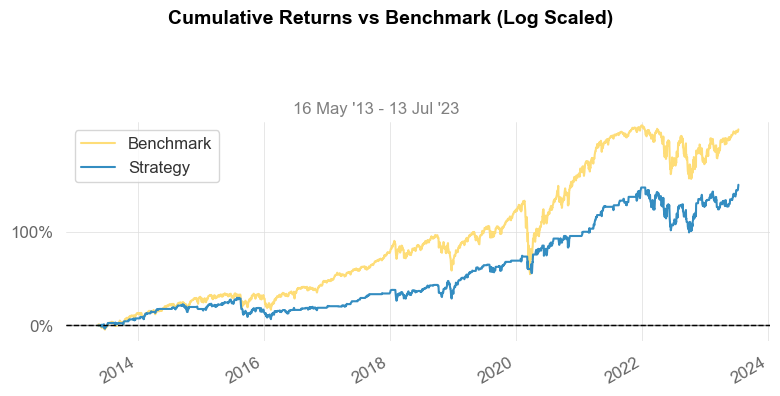

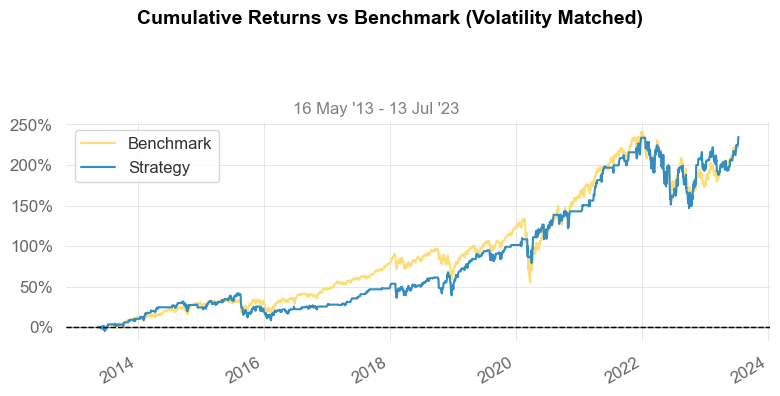

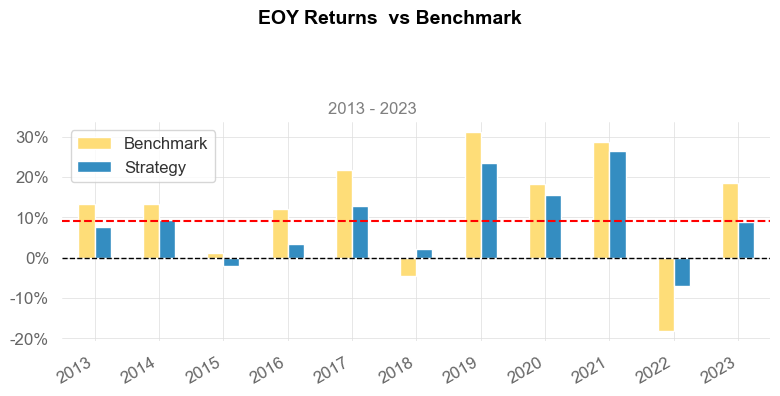

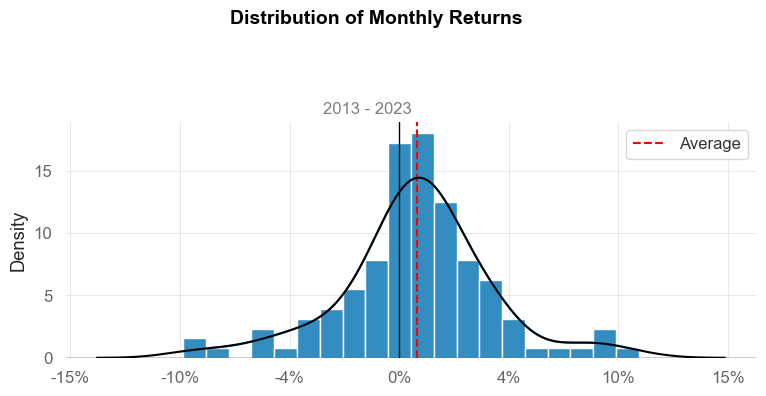

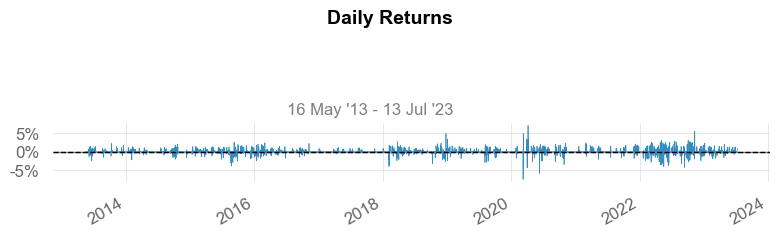

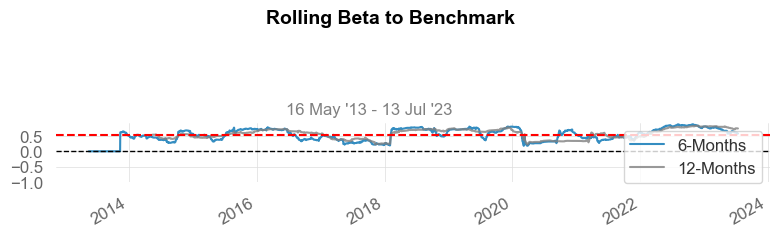

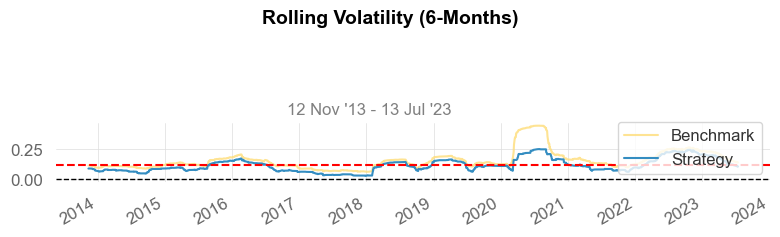

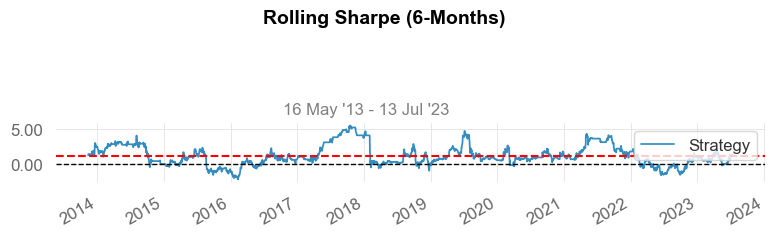

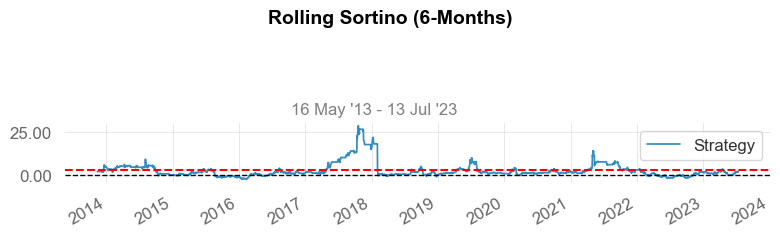

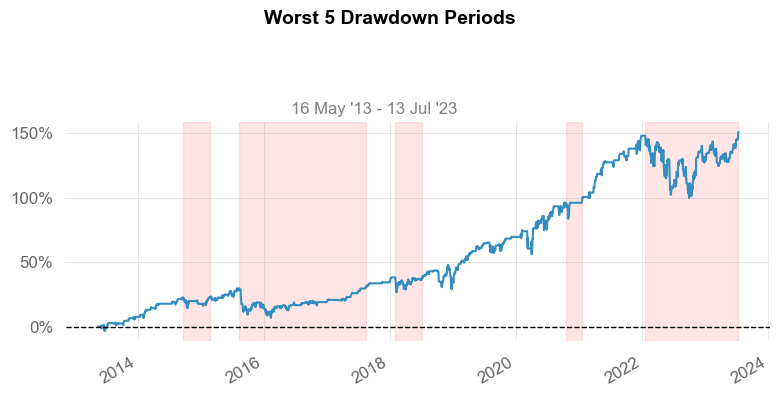

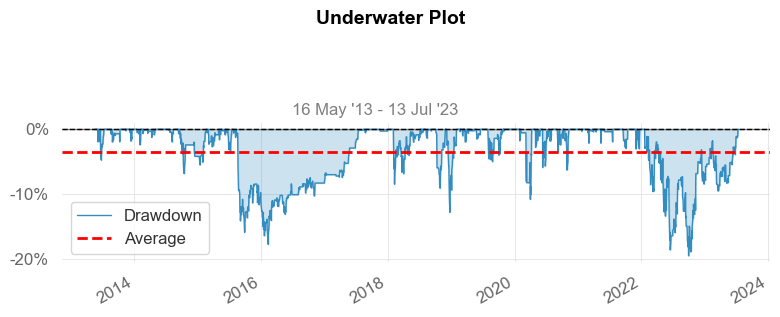

/opt/anaconda3/lib/python3.9/site-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


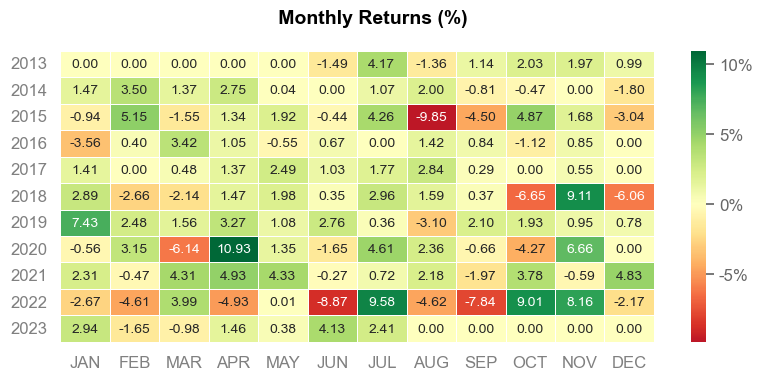

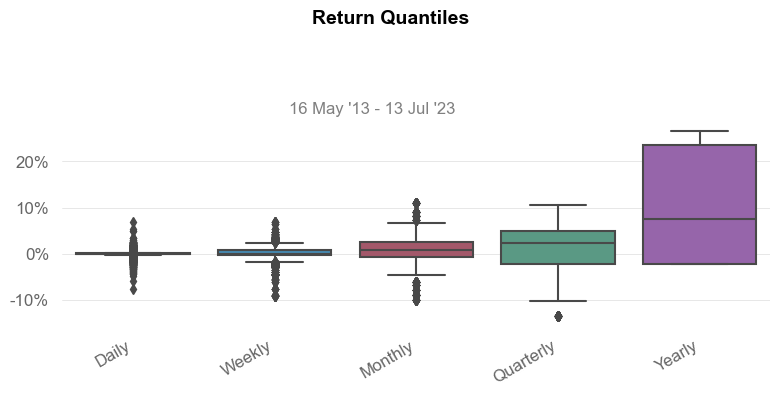

In [163]:
spy_data = yf.Ticker('^SPX').history(period="max")
spy_data.index = spy_data.index.tz_localize(None)
spy_data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

ticker_df = spy_data.copy()
ticker_df['ROC'] = ta.momentum.ROCIndicator(ticker_df['Close'], window=10).roc()
ticker_df['SMA'] = ta.trend.ema_indicator(ticker_df['Close'], window=10)
ticker_df['ATR'] = ta.volatility.AverageTrueRange(high=ticker_df['High'], 
                                                 low=ticker_df['Low'], 
                                                 close=ticker_df['Close'], window=13).average_true_range()
ticker_df['%_change'] = ticker_df['Close'].pct_change()
ticker_df['%_change + 1'] = ticker_df['%_change'].shift(-1)
ticker_df['y_label'] = [int(label) for label in ticker_df['%_change + 1'] > 0]
ticker_df['y_label'][-1] = np.nan
ticker_df.dropna(inplace=True)

ticker_df.drop(['Open', 'High', 'Low', '%_change', '%_change + 1'], axis=1, inplace=True)

# training_data_index = int(len(ticker_df)*.6)
train_period = ticker_df.loc[:'2013-05-16']
strategy_period = ticker_df.loc['2013-05-16':'2023-07-13']

open_date, close_date, equity_list = Two_model_combine_strategy(train_period, strategy_period, 41, model2_predict_df)
equity_list = pd.Series(equity_list, index=strategy_period.index)

benchmark = qs.utils.download_returns('SPY')
benchmark.index = benchmark.index.tz_localize(None)
qs.reports.full((equity_list), benchmark=benchmark)

<h1> Combine all

In [171]:
def Three_model_combine_strategy(train_df, strategy_df, n, model2_prediction_df, model3_prediction_df, sentiment_score):
    
    initial_capital = 100000
    lot = 0
    last_realized_capital = initial_capital
    unrealized_pnl = 0
    equity =  last_realized_capital + unrealized_pnl
    open_price = 0
    equity_list = []
    open_date = []
    close_date = []
    
    X = train_df.drop('y_label', axis=1)
    y = train_df['y_label']
    
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X.values, y)
    
    for date, row in strategy_df.iterrows():
        
        unrealized_pnl = (row['Close']-open_price)*lot
        equity =  last_realized_capital + unrealized_pnl
        
        input_feature = row.drop('y_label')
        KNN_prediction = knn.predict(np.array(input_feature).reshape(1,-1))[0]
        
        if KNN_prediction == 1 and model2_prediction_df.loc[date]['Buy_signal'] == 1 and model3_prediction_df.loc[date]['sentiment'] > sentiment_score:
            
            if lot == 0:
                open_price = row['Close']
                lot = last_realized_capital // open_price
                open_date.append(date)
#             elif lot < 0:
#                 close_price = row['Close']
#                 realized_pnl = unrealized_pnl
#                 last_realized_capital += realized_pnl
                
#                 open_price = row['Close']
#                 lot = last_realized_capital // open_price
        
        elif KNN_prediction == 0 and model2_prediction_df.loc[date]['Buy_signal'] == 0 and model3_prediction_df.loc[date]['sentiment'] < sentiment_score: 
            # if lot == 0:
            #     open_price = row['Close']
            #     lot = -last_realized_capital // open_price
            if lot > 0:
                close_price = row['Close']
                realized_pnl = unrealized_pnl
                last_realized_capital += realized_pnl
                lot = 0
                close_date.append(date)
                # open_price = row['Close']
                # lot = -last_realized_capital // open_price
        
        equity_list.append(equity)
        
        if strategy_df.index[0] != date:
            new_data_point = strategy_df.iloc[strategy_df.index.get_loc(date)-1]
            train_df = pd.concat([train_df, new_data_point.to_frame().T], axis=0)
            X = train_df.drop('y_label', axis=1)
            y = train_df['y_label']
            knn.fit(X.values, y)
    
    return open_date, close_date, equity_list

In [172]:
model3_prediction_df = pd.read_csv('SPX_sentiment.csv')
model3_prediction_df.set_index('Date', inplace=True)

model3_prediction_df.index = pd.to_datetime(model3_prediction_df.index)
model3_prediction_df.index = model3_prediction_df.index.tz_localize(None)

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2023-06-20  2023-06-20
End Period                 2023-07-13  2023-07-13
Risk-Free Rate             0.0%        0.0%
Time in Market             89.0%       95.0%

Cumulative Return          3.18%       2.83%
CAGR﹪                     64.24%      55.76%

Sharpe                     5.07        4.35
Prob. Sharpe Ratio         90.73%      87.04%
Smart Sharpe               4.09        3.51
Sortino                    10.2        8.34
Smart Sortino              8.22        6.72
Sortino/√2                 7.21        5.9
Smart Sortino/√2           5.81        4.75
Omega                      2.3         2.3

Max Drawdown               -1.22%      -1.31%
Longest DD Days            7           8
Volatility (ann.)          9.22%       9.62%
R^2                        0.95        0.95
Information Ratio          0.15        0.15
Calmar                     52.57       42.47
S

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-07-05,2023-07-07,2023-07-12,7,-1.221905,-0.993669
2,2023-06-23,2023-06-26,2023-06-29,6,-1.163400,-0.735699


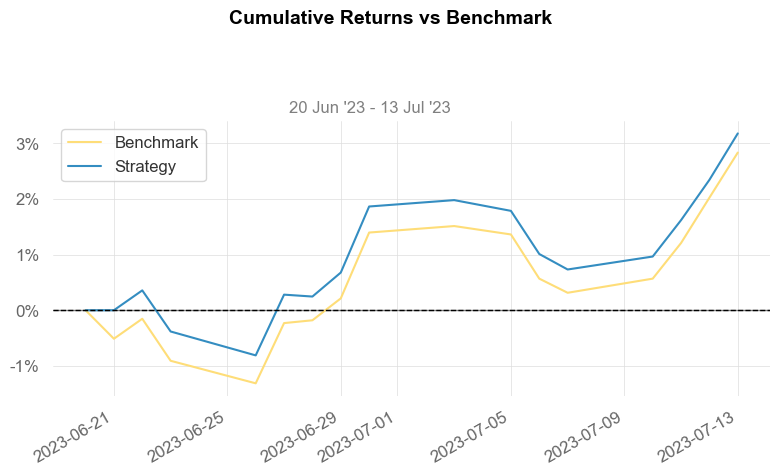

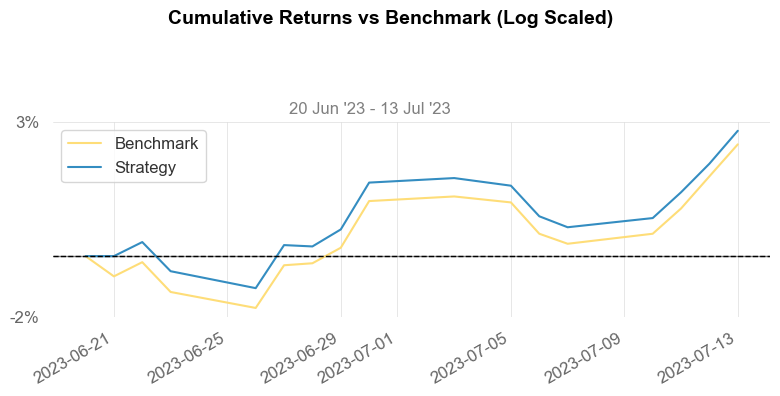

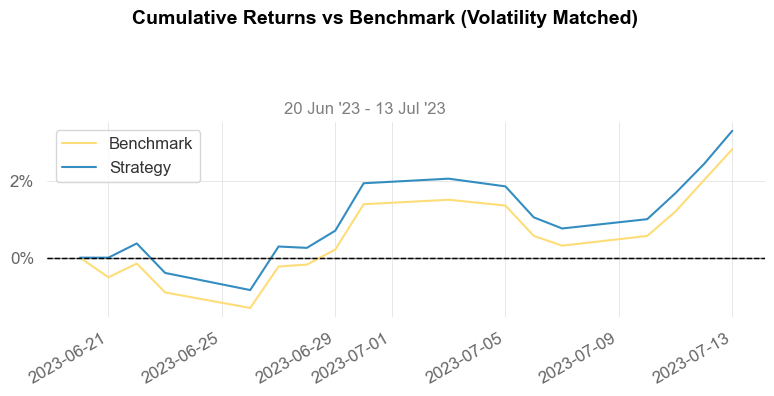

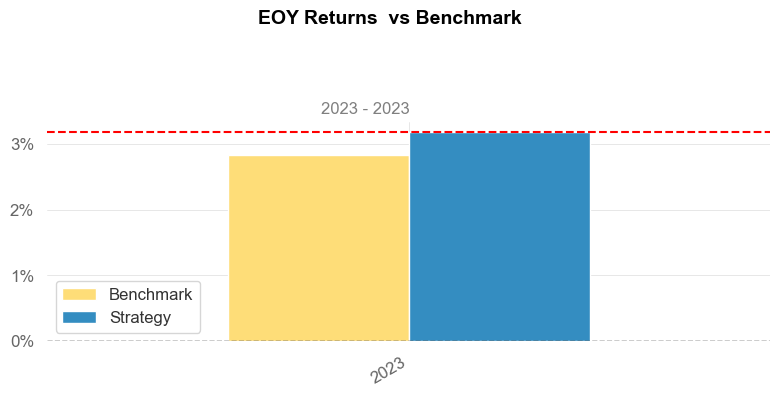

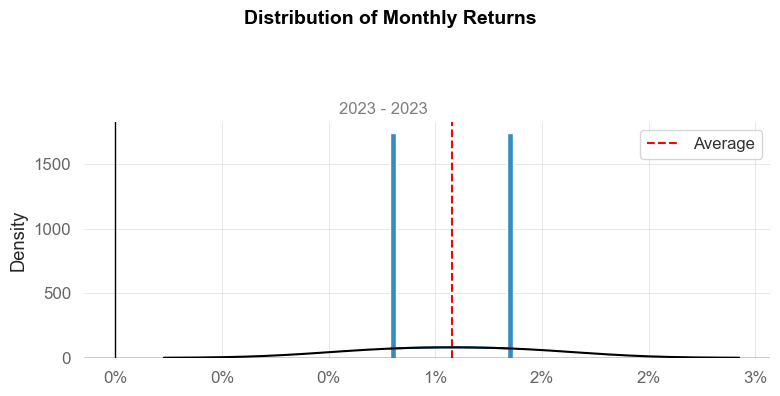

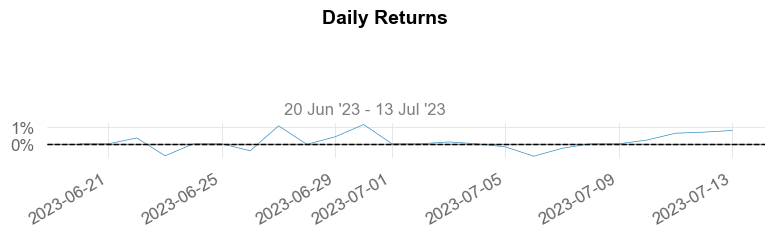

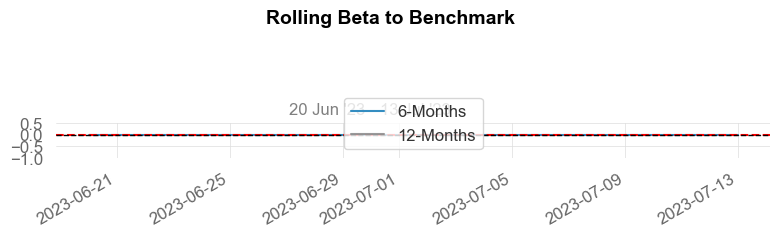

IndexError: index 0 is out of bounds for axis 0 with size 0

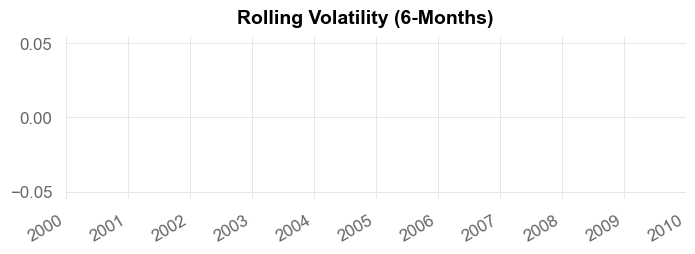

In [177]:
spy_data = yf.Ticker('^SPX').history(period="max")
spy_data.index = spy_data.index.tz_localize(None)
spy_data.drop(['Dividends', 'Stock Splits'], axis=1, inplace=True)

ticker_df = spy_data.copy()
ticker_df['ROC'] = ta.momentum.ROCIndicator(ticker_df['Close'], window=10).roc()
ticker_df['SMA'] = ta.trend.ema_indicator(ticker_df['Close'], window=10)
ticker_df['ATR'] = ta.volatility.AverageTrueRange(high=ticker_df['High'], 
                                                 low=ticker_df['Low'], 
                                                 close=ticker_df['Close'], window=13).average_true_range()
ticker_df['%_change'] = ticker_df['Close'].pct_change()
ticker_df['%_change + 1'] = ticker_df['%_change'].shift(-1)
ticker_df['y_label'] = [int(label) for label in ticker_df['%_change + 1'] > 0]
ticker_df['y_label'][-1] = np.nan
ticker_df.dropna(inplace=True)

ticker_df.drop(['Open', 'High', 'Low', '%_change', '%_change + 1'], axis=1, inplace=True)

# training_data_index = int(len(ticker_df)*.6)
train_period = ticker_df.loc[:'2023-06-17']
strategy_period = ticker_df.loc['2023-06-17':'2023-07-13']

open_date, close_date, equity_list = Three_model_combine_strategy(train_period, strategy_period, 41, model2_predict_df, model3_prediction_df, 0.5)
equity_list = pd.Series(equity_list, index=strategy_period.index)

benchmark = qs.utils.download_returns('SPY')
benchmark.index = benchmark.index.tz_localize(None)
qs.reports.full((equity_list), benchmark=benchmark)